In [1]:
import gspread
import pandas as pd
import re
from gspread_dataframe import get_as_dataframe
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import numpy as np

In [2]:
CREDENTIALS_JSON = "../rm4mt-463314-3ce1280ee29c.json"

orignal_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing",
]

post_editing_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/10C8f-Apb2r15mV8ONhigbE3AThf5NNqhldsIXbanMy4/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1uKV-kTp1Y_PmrTrE-v6SE6oDpra7_XmKheeUZS3SK6c/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1VrHKa2WqpXnKARvJuVKHQnzGhsEUi5XVK7jw9BIeaE4/edit?usp=sharing",
]

post_editing_without_quality_socre_sheet_urls = [
    "https://docs.google.com/spreadsheets/d/1u3aEeKBSjUpWe24tj54YjG-SSJERz3Z4-ZAbB50fQcM/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1lHvnIOX_qbBmNIejnzuNvvUa3wPkfkssRblUV3sYP7Y/edit?usp=sharing",
    "https://docs.google.com/spreadsheets/d/1gG-BP2AZUBUvq-jpIpf_HyKj3kSu-ztBffW28GrEDb4/edit?usp=sharing",
]

In [3]:
gc = gspread.service_account(filename=CREDENTIALS_JSON)
original_data = {}
post_editing_data = {}
post_editing_without_quality_score_data = {}

In [4]:
for sheet_url in orignal_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    original_data[sheet_url] = ws_data

for sheet_url in post_editing_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    post_editing_data[sheet_url] = ws_data

for sheet_url in post_editing_without_quality_socre_sheet_urls:
    print(f"Reading Sheet: {sheet_url}")
    spreadsheet = gc.open_by_url(sheet_url)
    ws_data = {}
    for worksheet in spreadsheet.worksheets():
        # print(f"  Worksheet: {worksheet.title}")
        df = get_as_dataframe(worksheet, evaluate_formulas=True)
        df = df.dropna(how="all").dropna(axis=1, how="all")
        ws_data[worksheet.title] = df
        time.sleep(2)
    post_editing_without_quality_score_data[sheet_url] = ws_data

Reading Sheet: https://docs.google.com/spreadsheets/d/1yhLFAwm-sFAG2cDxDBQ6C0smcM_f5uQxYuy_clvgueM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/19sowSDpBO42OSXFeBM92UBp1H2MZkQQWzEAPMpZz9q4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/16nVSzWScuuYThX2ZgQAyZ0V5ip5d1GFPKCABjG6IHf8/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/10C8f-Apb2r15mV8ONhigbE3AThf5NNqhldsIXbanMy4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1uKV-kTp1Y_PmrTrE-v6SE6oDpra7_XmKheeUZS3SK6c/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1VrHKa2WqpXnKARvJuVKHQnzGhsEUi5XVK7jw9BIeaE4/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1u3aEeKBSjUpWe24tj54YjG-SSJERz3Z4-ZAbB50fQcM/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1lHvnIOX_qbBmNIejnzuNvvUa3wPkfkssRblUV3sYP7Y/edit?usp=sharing
Reading Sheet: https://docs.google.com/spreadsheets/d/1gG-BP2AZUBUvq-jpI

In [5]:
def split_by_metric(all_data):
    dfs_by_metric = defaultdict(list)  # metric: list of rows

    for sheet_url, ws_dict in all_data.items():
        for ws_name, df in ws_dict.items():
            match = re.match(
                r"(.+?)_((comet_score|comet_kiwi_score|grb|grf|gea_100|gea_5|thinking_length))$",
                ws_name,
            )
            if not match:
                continue
            task = match.group(1)
            metric = match.group(2)
            # Check must have model & lang_pair
            if not {"model", "lang_pair"}.issubset(df.columns):
                continue
            # Budget Column - include numeric columns and "low", "high"
            numeric_cols = [
                col
                for col in df.columns
                if isinstance(col, (int, float))
                or (isinstance(col, str) and col.isdigit())
            ]
            text_budget_cols = [col for col in df.columns if col in ["low", "high"]]
            budget_cols = sorted(numeric_cols, key=lambda x: int(x)) + text_budget_cols

            for _, row in df.iterrows():
                model = row["model"]
                lang_pair = row["lang_pair"]
                for budget in budget_cols:
                    val = row[budget]
                    if pd.isna(val):
                        continue
                    # Handle budget value - keep as string for "low"/"high", convert to int for numeric
                    budget_val = budget if budget in ["low", "high"] else int(budget)
                    dfs_by_metric[metric].append(
                        {
                            "model": model,
                            "task": task,
                            "metric": metric,
                            "lang_pair": lang_pair,
                            "budget": budget_val,
                            "score": float(val),
                        }
                    )

    # To DataFrame
    for metric in dfs_by_metric:
        dfs_by_metric[metric] = pd.DataFrame(dfs_by_metric[metric])

    return dfs_by_metric

In [6]:
dfs_original_by_comet = split_by_metric(original_data)["comet_score"]
dfs_post_editing_by_comet = split_by_metric(post_editing_data)["comet_score"]
dfs_post_editing_without_quality_score_by_comet = split_by_metric(
    post_editing_without_quality_score_data
)["comet_score"]

dfs_original_by_comet_kiwi = split_by_metric(original_data)["comet_kiwi_score"]
dfs_post_editing_by_comet_kiwi = split_by_metric(post_editing_data)["comet_kiwi_score"]
dfs_post_editing_without_quality_score_by_comet_kiwi = split_by_metric(
    post_editing_without_quality_score_data
)["comet_kiwi_score"]

dfs_original_by_grb = split_by_metric(original_data)["grb"]
dfs_post_editing_by_grb = split_by_metric(post_editing_data)["grb"]
dfs_post_editing_without_quality_score_by_grb = split_by_metric(
    post_editing_without_quality_score_data
)["grb"]

dfs_original_by_grf = split_by_metric(original_data)["grf"]
dfs_post_editing_by_grf = split_by_metric(post_editing_data)["grf"]
dfs_post_editing_without_quality_score_by_grf = split_by_metric(
    post_editing_without_quality_score_data
)["grf"]

dfs_original_by_gea_5 = split_by_metric(original_data)["gea_5"]
dfs_post_editing_by_gea_5 = split_by_metric(post_editing_data)["gea_5"]
dfs_post_editing_without_quality_score_by_gea_5 = split_by_metric(
    post_editing_without_quality_score_data
)["gea_5"]

dfs_original_by_gea_100 = split_by_metric(original_data)["gea_100"]
dfs_post_editing_by_gea_100 = split_by_metric(post_editing_data)["gea_100"]
dfs_post_editing_without_quality_score_by_gea_100 = split_by_metric(
    post_editing_without_quality_score_data
)["gea_100"]

In [7]:
def visualize_qwen_models_comparison(
    dfs_original_by_comet,
    dfs_post_editing_by_comet,
    dfs_post_editing_without_quality_score_by_comet,
):

    qwen_models = [
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ]

    df_original_filtered = dfs_original_by_comet[
        (dfs_original_by_comet["model"].isin(qwen_models))
        & (dfs_original_by_comet["budget"] == 0)
        & (dfs_original_by_comet["lang_pair"] == "Avg")
    ].copy()
    df_original_filtered["data_type"] = "Original"

    df_post_editing_filtered = dfs_post_editing_by_comet[
        (dfs_post_editing_by_comet["model"].isin(qwen_models))
        & (dfs_post_editing_by_comet["budget"].isin([0, 500, 1000]))
    ].copy()
    df_post_editing_filtered["data_type"] = "Post-editing"

    df_post_editing_no_quality_filtered = (
        dfs_post_editing_without_quality_score_by_comet[
            (dfs_post_editing_without_quality_score_by_comet["model"].isin(qwen_models))
            & (
                dfs_post_editing_without_quality_score_by_comet["budget"].isin(
                    [0, 500, 1000]
                )
            )
        ].copy()
    )
    df_post_editing_no_quality_filtered["data_type"] = "Post-editing (No Quality Score)"

    all_data = pd.concat(
        [
            df_original_filtered,
            df_post_editing_filtered,
            df_post_editing_no_quality_filtered,
        ],
        ignore_index=True,
    )

    all_data["group_id"] = (
        all_data["data_type"] + "_budget_" + all_data["budget"].astype(str)
    )

    tasks = sorted(all_data["task"].unique())

    n_tasks = len(tasks)
    n_cols = 3  # 每行3个子图
    n_rows = (n_tasks + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Order：Original, Post-editing No QS (0,500,1000), Post-editing QS (0,500,1000)
    group_order = [
        "Original_budget_0",
        "Post-editing (No Quality Score)_budget_0",
        "Post-editing (No Quality Score)_budget_500",
        "Post-editing (No Quality Score)_budget_1000",
        "Post-editing_budget_0",
        "Post-editing_budget_500",
        "Post-editing_budget_1000",
    ]

    # Define colors - use color gradient
    group_info = {
        "Original_budget_0": {"color": "#1f77b4", "label": "Original (budget=0)"},
        # Post-editing No QS - green gradient
        "Post-editing (No Quality Score)_budget_0": {
            "color": "#90EE90",
            "label": "Post-editing No QS (budget=0)",
        },
        "Post-editing (No Quality Score)_budget_500": {
            "color": "#32CD32",
            "label": "Post-editing No QS (budget=500)",
        },
        "Post-editing (No Quality Score)_budget_1000": {
            "color": "#228B22",
            "label": "Post-editing No QS (budget=1000)",
        },
        # Post-editing QS - red gradient
        "Post-editing_budget_0": {
            "color": "#FFB6C1",
            "label": "Post-editing QS (budget=0)",
        },
        "Post-editing_budget_500": {
            "color": "#FF6347",
            "label": "Post-editing QS (budget=500)",
        },
        "Post-editing_budget_1000": {
            "color": "#DC143C",
            "label": "Post-editing QS (budget=1000)",
        },
    }

    legend_handles = []
    legend_labels = []

    for idx, task in enumerate(tasks):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]

        task_data = all_data[all_data["task"] == task]

        task_summary = (
            task_data.groupby(["model", "group_id"])["score"].mean().reset_index()
        )

        pivot_data = task_summary.pivot(
            index="model", columns="group_id", values="score"
        )

        def get_model_size(model_name):
            import re

            m = re.search(r"(\d+(\.\d+)?)B", model_name)
            if m:
                return float(m.group(1))
            return float("inf")

        pivot_data = pivot_data.reindex(sorted(pivot_data.index, key=get_model_size))

        bar_width = 0.12
        x_pos = np.arange(len(pivot_data.index))

        for i, group in enumerate(group_order):
            if group in pivot_data.columns and group in group_info:
                offset = (i - len(group_order) / 2 + 0.5) * bar_width
                bars = ax.bar(
                    x_pos + offset,
                    pivot_data[group],
                    bar_width,
                    color=group_info[group]["color"],
                    alpha=0.8,
                )

                if idx == 0:
                    legend_handles.append(bars[0])
                    legend_labels.append(group_info[group]["label"])

        ax.set_xlabel("Model")
        ax.set_ylabel("COMET Score")
        ax.set_title(f"Task: {task}")
        ax.set_xticks(x_pos)
        ax.set_xticklabels(pivot_data.index, rotation=45, ha="right")
        ax.grid(True, alpha=0.3)

    # Hide extra subplots
    for idx in range(len(tasks), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)

    # Add a unified legend
    fig.legend(
        legend_handles,
        legend_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 1.02),
        ncol=4,
        fontsize="small",
    )

    plt.tight_layout()
    plt.show()

In [8]:
def generate_improvement_table(
    dfs_original_by_comet,
    dfs_post_editing_by_comet,
    dfs_post_editing_without_quality_score_by_comet,
):
    """
    生成相对于Original的改进表格

    参数:
    - dfs_original_by_comet: 原始数据的COMET分数DataFrame
    - dfs_post_editing_by_comet: 后编辑数据的COMET分数DataFrame
    - dfs_post_editing_without_quality_score_by_comet: 无质量分数后编辑数据的COMET分数DataFrame

    返回:
    - improvement_table: 改进表格DataFrame
    """

    qwen_models = [
        "Qwen3-0.6B",
        "Qwen3-1.7B",
        "Qwen3-4B",
        "Qwen3-8B",
        "Qwen3-14B",
        "Qwen3-32B",
    ]

    # 添加lang_pair="Avg"的筛选条件
    df_original_filtered = dfs_original_by_comet[
        (dfs_original_by_comet["model"].isin(qwen_models))
        & (dfs_original_by_comet["budget"] == 0)
        & (dfs_original_by_comet["lang_pair"] == "Avg")
    ].copy()
    df_original_filtered["data_type"] = "Original"

    df_post_editing_filtered = dfs_post_editing_by_comet[
        (dfs_post_editing_by_comet["model"].isin(qwen_models))
        & (dfs_post_editing_by_comet["budget"].isin([0, 500, 1000]))
        & (dfs_post_editing_by_comet["lang_pair"] == "Avg")
    ].copy()
    df_post_editing_filtered["data_type"] = "Post-editing"

    df_post_editing_no_quality_filtered = (
        dfs_post_editing_without_quality_score_by_comet[
            (dfs_post_editing_without_quality_score_by_comet["model"].isin(qwen_models))
            & (
                dfs_post_editing_without_quality_score_by_comet["budget"].isin(
                    [0, 500, 1000]
                )
            )
            & (dfs_post_editing_without_quality_score_by_comet["lang_pair"] == "Avg")
        ].copy()
    )
    df_post_editing_no_quality_filtered["data_type"] = "Post-editing (No Quality Score)"

    all_data = pd.concat(
        [
            df_original_filtered,
            df_post_editing_filtered,
            df_post_editing_no_quality_filtered,
        ],
        ignore_index=True,
    )

    # 创建组合标识符
    all_data["group_id"] = (
        all_data["data_type"] + "_budget_" + all_data["budget"].astype(str)
    )

    # 按任务、模型、组合分组并计算平均分数
    summary_data = (
        all_data.groupby(["task", "model", "group_id"])["score"].mean().reset_index()
    )

    # 获取所有唯一的任务和模型
    tasks = sorted(summary_data["task"].unique())
    models = sorted(
        summary_data["model"].unique(),
        key=lambda x: float(re.search(r"(\d+(\.\d+)?)B", x).group(1)),
    )

    # 定义设置顺序（除了Original）
    settings_order = [
        "Post-editing (No Quality Score)_budget_0",
        "Post-editing (No Quality Score)_budget_500",
        "Post-editing (No Quality Score)_budget_1000",
        "Post-editing_budget_0",
        "Post-editing_budget_500",
        "Post-editing_budget_1000",
    ]

    # 设置标签映射
    setting_labels = {
        "Post-editing (No Quality Score)_budget_0": "Post-editing No QS (budget=0)",
        "Post-editing (No Quality Score)_budget_500": "Post-editing No QS (budget=500)",
        "Post-editing (No Quality Score)_budget_1000": "Post-editing No QS (budget=1000)",
        "Post-editing_budget_0": "Post-editing QS (budget=0)",
        "Post-editing_budget_500": "Post-editing QS (budget=500)",
        "Post-editing_budget_1000": "Post-editing QS (budget=1000)",
    }

    # 创建结果列表
    results = []

    for task in tasks:
        for model in models:
            # 获取Original的分数作为基准
            original_score = summary_data[
                (summary_data["task"] == task)
                & (summary_data["model"] == model)
                & (summary_data["group_id"] == "Original_budget_0")
            ]["score"].values

            if len(original_score) == 0:
                continue
            original_score = original_score[0]

            row_data = {
                "Task": task,
                "Model": model,
                "Original Score": original_score,
            }

            # 计算每个设置相对于Original的改进
            for setting in settings_order:
                setting_score = summary_data[
                    (summary_data["task"] == task)
                    & (summary_data["model"] == model)
                    & (summary_data["group_id"] == setting)
                ]["score"].values

                # if len(setting_score) > 0:
                #     setting_score = setting_score[0]
                #     # 计算绝对改进和相对改进百分比
                #     absolute_improvement = setting_score - original_score
                #     relative_improvement = (absolute_improvement / original_score) * 100

                #     # 格式化显示：绝对改进 (相对改进%)
                #     improvement_str = (
                #         f"{absolute_improvement:+.4f} ({relative_improvement:+.2f}%)"
                #     )
                #     row_data[setting_labels[setting]] = improvement_str
                # else:
                #     row_data[setting_labels[setting]] = "N/A"

                row_data[setting_labels[setting]] = setting_score[0]

            results.append(row_data)

    # 转换为DataFrame
    improvement_table = pd.DataFrame(results)

    # 调整列顺序
    columns_order = ["Task", "Model", "Original Score"] + [
        setting_labels[s] for s in settings_order
    ]
    improvement_table = improvement_table[columns_order]

    return improvement_table

#### Comet


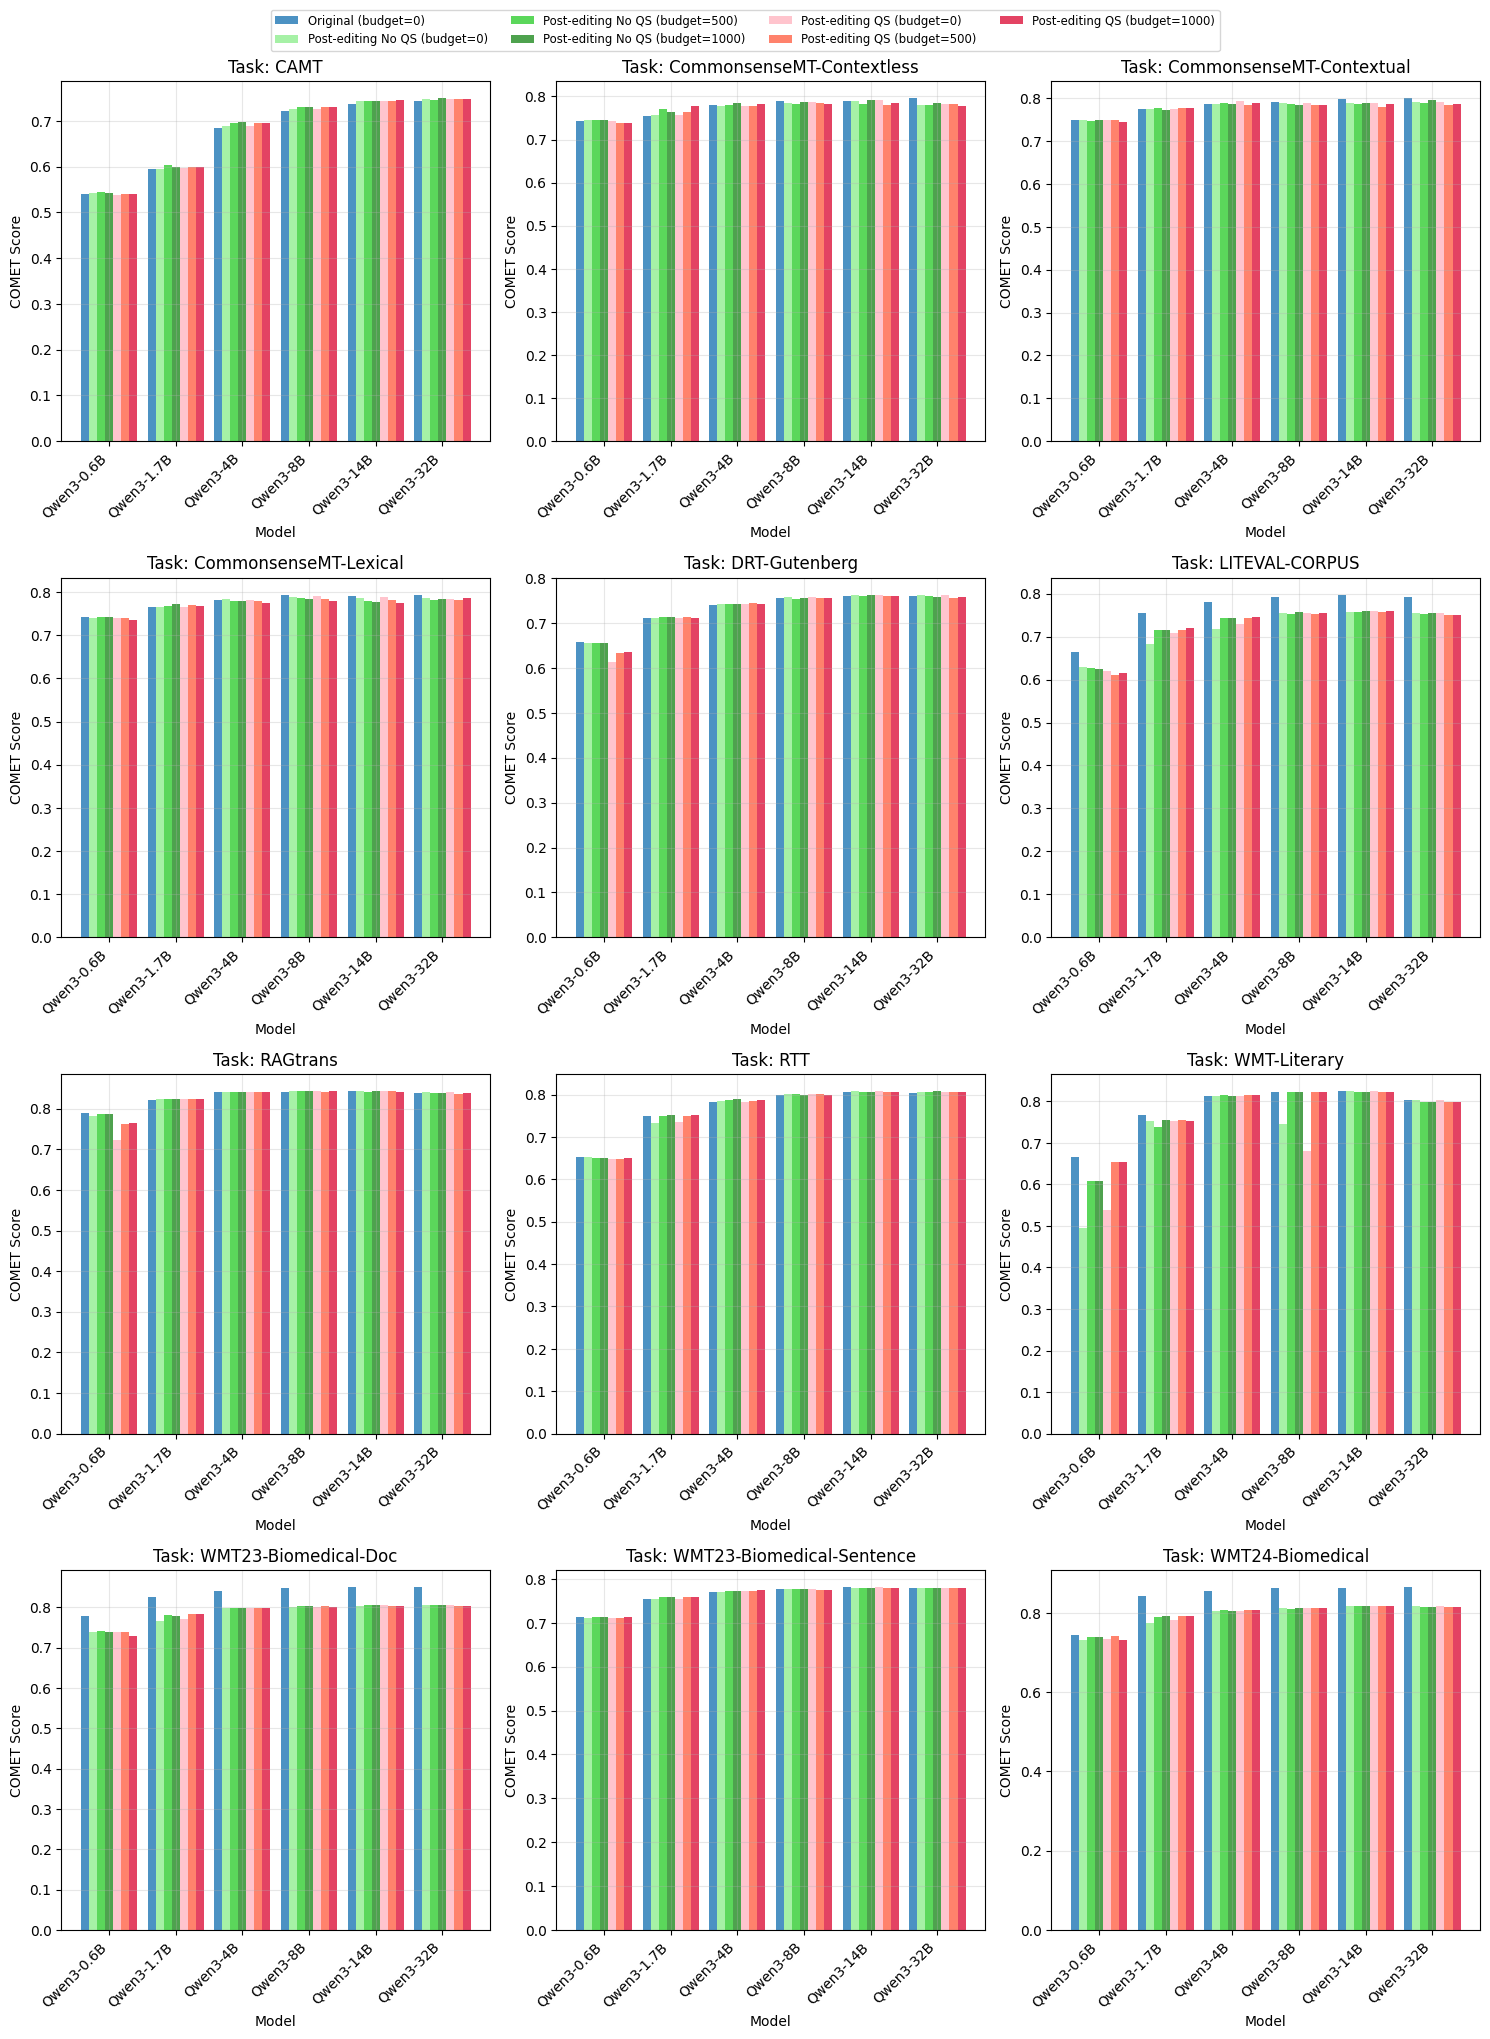

In [9]:
visualize_qwen_models_comparison(
    dfs_original_by_comet,
    dfs_post_editing_by_comet,
    dfs_post_editing_without_quality_score_by_comet,
)

In [10]:
improvement_df = generate_improvement_table(
    dfs_original_by_comet,
    dfs_post_editing_by_comet,
    dfs_post_editing_without_quality_score_by_comet
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,CAMT,Qwen3-0.6B,0.541192,0.542475,0.544912,0.542972,0.539147,0.540848,0.540404
1,CAMT,Qwen3-1.7B,0.594895,0.594559,0.604560,0.599594,0.596151,0.598712,0.598971
2,CAMT,Qwen3-4B,0.684124,0.689407,0.694866,0.697536,0.688905,0.696367,0.696541
3,CAMT,Qwen3-8B,0.721632,0.726387,0.729797,0.730005,0.726696,0.730270,0.729496
4,CAMT,Qwen3-14B,0.737924,0.743449,0.744404,0.743458,0.743754,0.743443,0.745753
...,...,...,...,...,...,...,...,...,...
67,WMT24-Biomedical,Qwen3-1.7B,0.842714,0.774720,0.789475,0.791198,0.782081,0.793310,0.793114
68,WMT24-Biomedical,Qwen3-4B,0.855716,0.805202,0.806702,0.805904,0.805493,0.807083,0.807594
69,WMT24-Biomedical,Qwen3-8B,0.862497,0.812458,0.810826,0.811309,0.812352,0.812036,0.811899
70,WMT24-Biomedical,Qwen3-14B,0.864236,0.816342,0.817478,0.816551,0.816444,0.817153,0.817499


#### Comet-Kiki


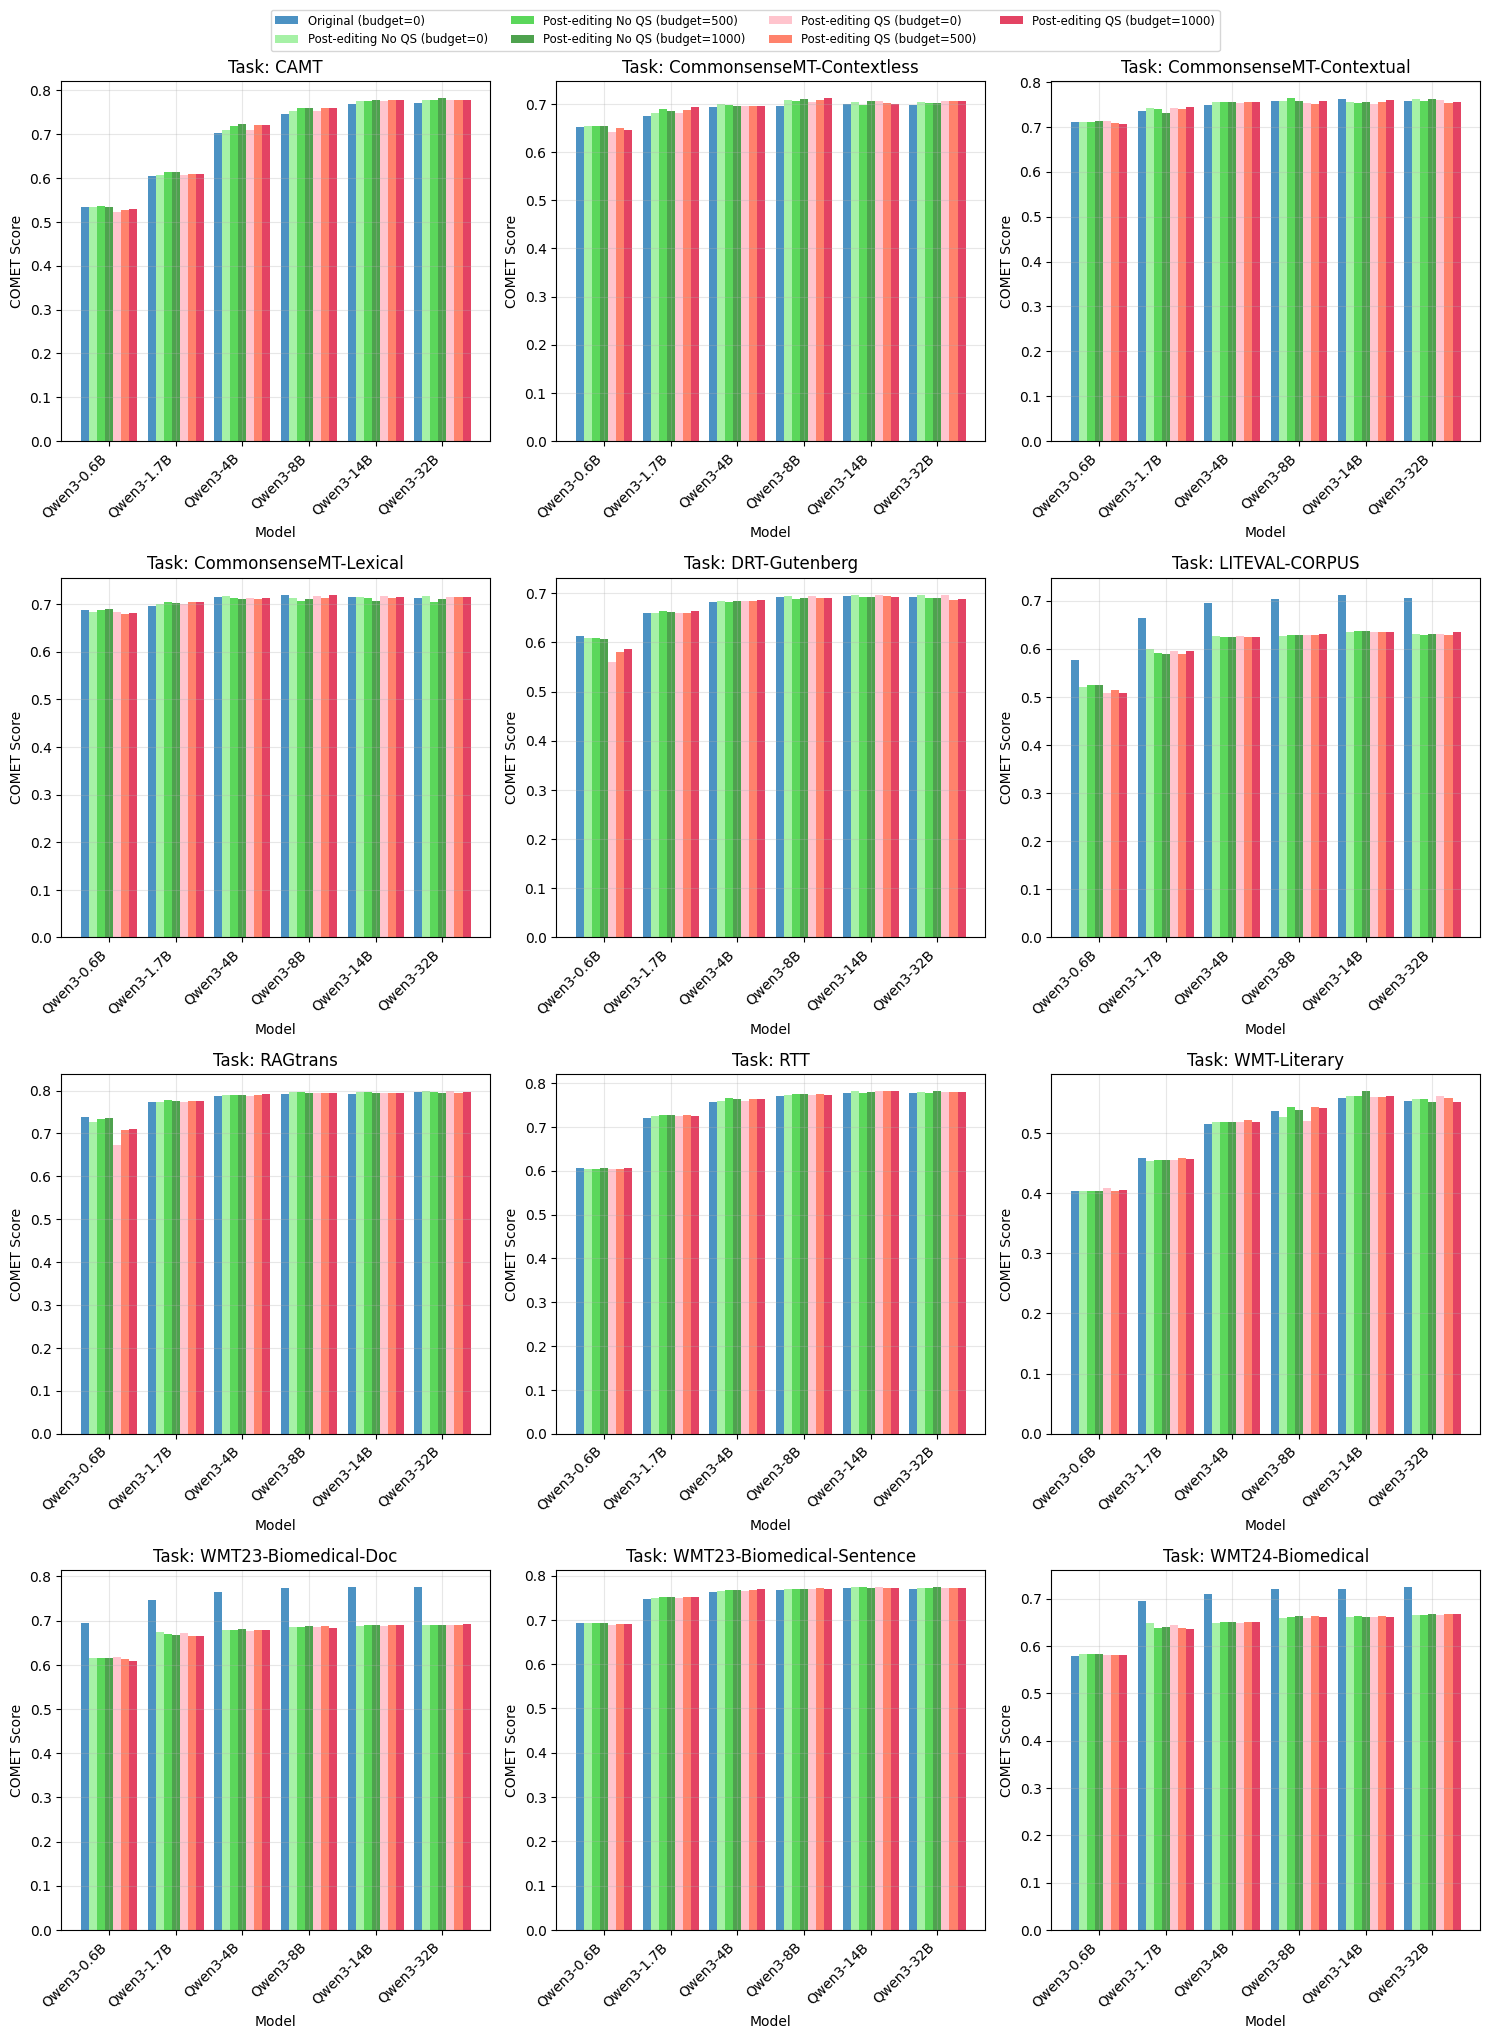

In [11]:
visualize_qwen_models_comparison(
    dfs_original_by_comet_kiwi,
    dfs_post_editing_by_comet_kiwi,
    dfs_post_editing_without_quality_score_by_comet_kiwi,
)

In [16]:
improvement_df = generate_improvement_table(
    dfs_original_by_comet_kiwi,
    dfs_post_editing_by_comet_kiwi,
    dfs_post_editing_without_quality_score_by_comet_kiwi,
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,CAMT,Qwen3-0.6B,0.533191,0.533516,0.534992,0.533460,0.523477,0.527819,0.528385
1,CAMT,Qwen3-1.7B,0.604136,0.605794,0.613949,0.613517,0.605852,0.609243,0.609900
2,CAMT,Qwen3-4B,0.702847,0.709880,0.719121,0.722681,0.709425,0.719770,0.720815
3,CAMT,Qwen3-8B,0.745885,0.753278,0.758990,0.759936,0.752563,0.758734,0.758964
4,CAMT,Qwen3-14B,0.768175,0.776539,0.776298,0.776720,0.775788,0.776773,0.778380
...,...,...,...,...,...,...,...,...,...
67,WMT24-Biomedical,Qwen3-1.7B,0.694305,0.649194,0.638804,0.639492,0.643866,0.637208,0.636507
68,WMT24-Biomedical,Qwen3-4B,0.708699,0.648928,0.649740,0.650378,0.648129,0.651035,0.649722
69,WMT24-Biomedical,Qwen3-8B,0.719236,0.659239,0.660795,0.662638,0.659967,0.662367,0.660922
70,WMT24-Biomedical,Qwen3-14B,0.720831,0.660993,0.662769,0.660857,0.660890,0.663993,0.661179


#### GRB

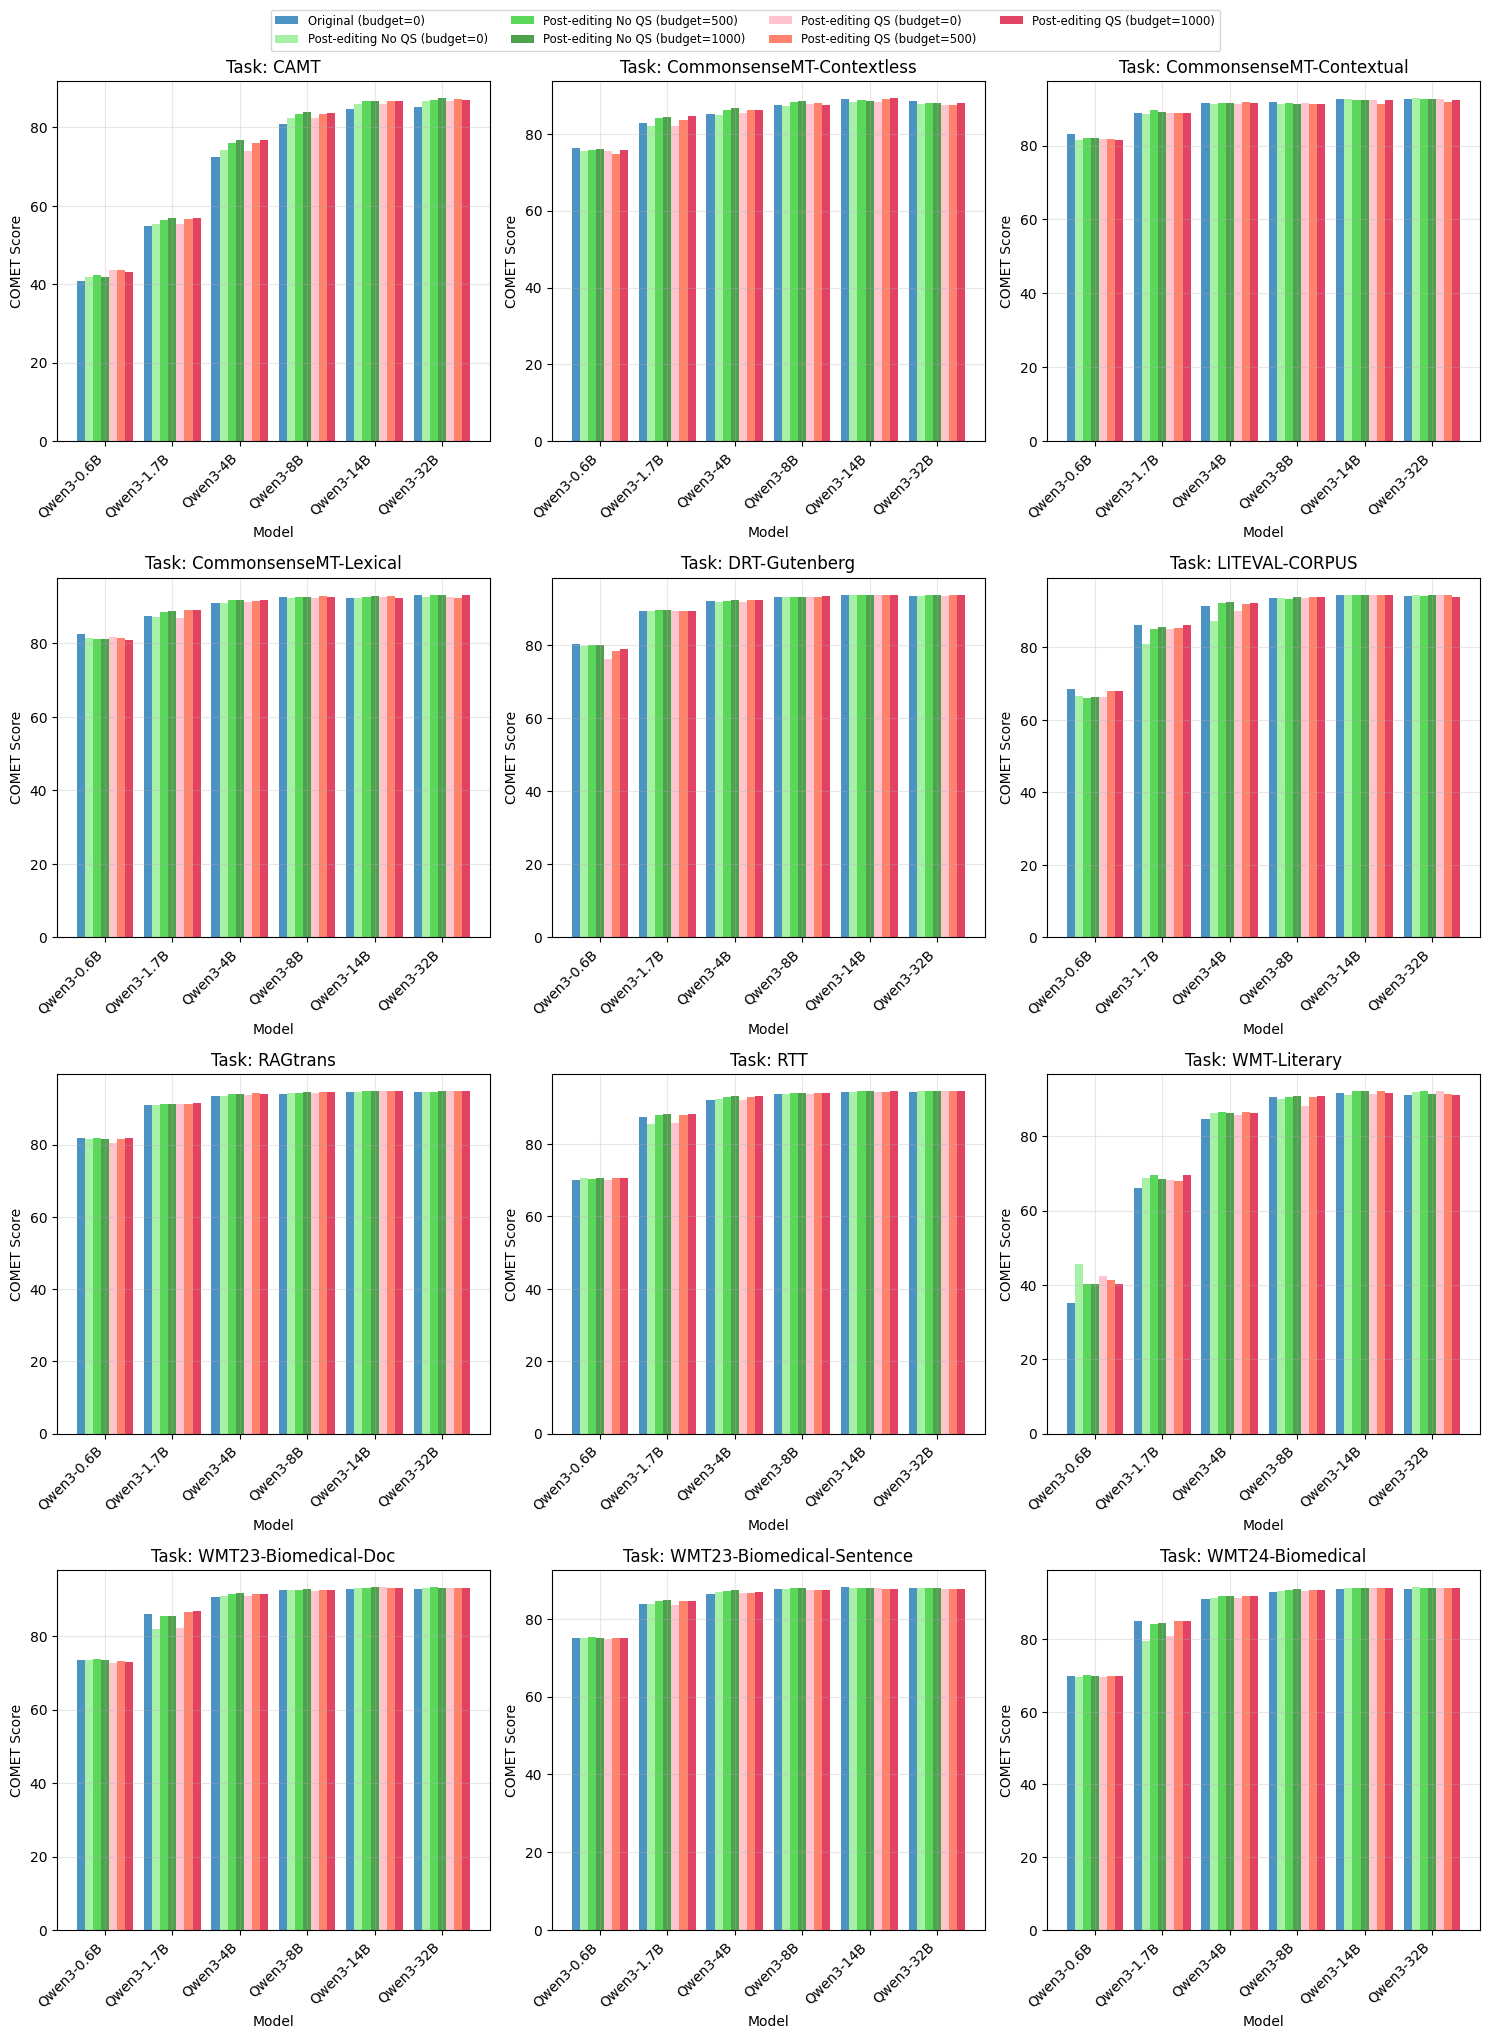

In [12]:
visualize_qwen_models_comparison(
    dfs_original_by_grb,
    dfs_post_editing_by_grb,
    dfs_post_editing_without_quality_score_by_grb,
)

In [17]:
improvement_df = generate_improvement_table(
    dfs_original_by_grb,
    dfs_post_editing_by_grb,
    dfs_post_editing_without_quality_score_by_grb,
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,CAMT,Qwen3-0.6B,40.751877,41.805339,42.261468,41.972202,43.582953,43.711247,43.146649
1,CAMT,Qwen3-1.7B,54.888757,55.364710,56.481173,56.824046,55.452836,56.622535,56.938647
2,CAMT,Qwen3-4B,72.529841,74.189551,76.125789,76.871677,74.065294,76.054397,76.882521
3,CAMT,Qwen3-8B,80.822582,82.434618,83.529373,83.850779,82.353431,83.514615,83.681702
4,CAMT,Qwen3-14B,84.822753,85.950855,86.650428,86.735078,85.973725,86.628513,86.759205
...,...,...,...,...,...,...,...,...,...
67,WMT24-Biomedical,Qwen3-1.7B,85.013333,79.523333,84.208333,84.518333,80.900000,84.955000,85.021667
68,WMT24-Biomedical,Qwen3-4B,90.913333,91.290000,91.930000,91.818333,91.181667,91.848333,91.971667
69,WMT24-Biomedical,Qwen3-8B,92.996667,93.321667,93.473333,93.678333,93.355000,93.465000,93.508333
70,WMT24-Biomedical,Qwen3-14B,93.843333,94.050000,94.145000,94.111667,93.988333,94.156667,94.123333


#### GRF

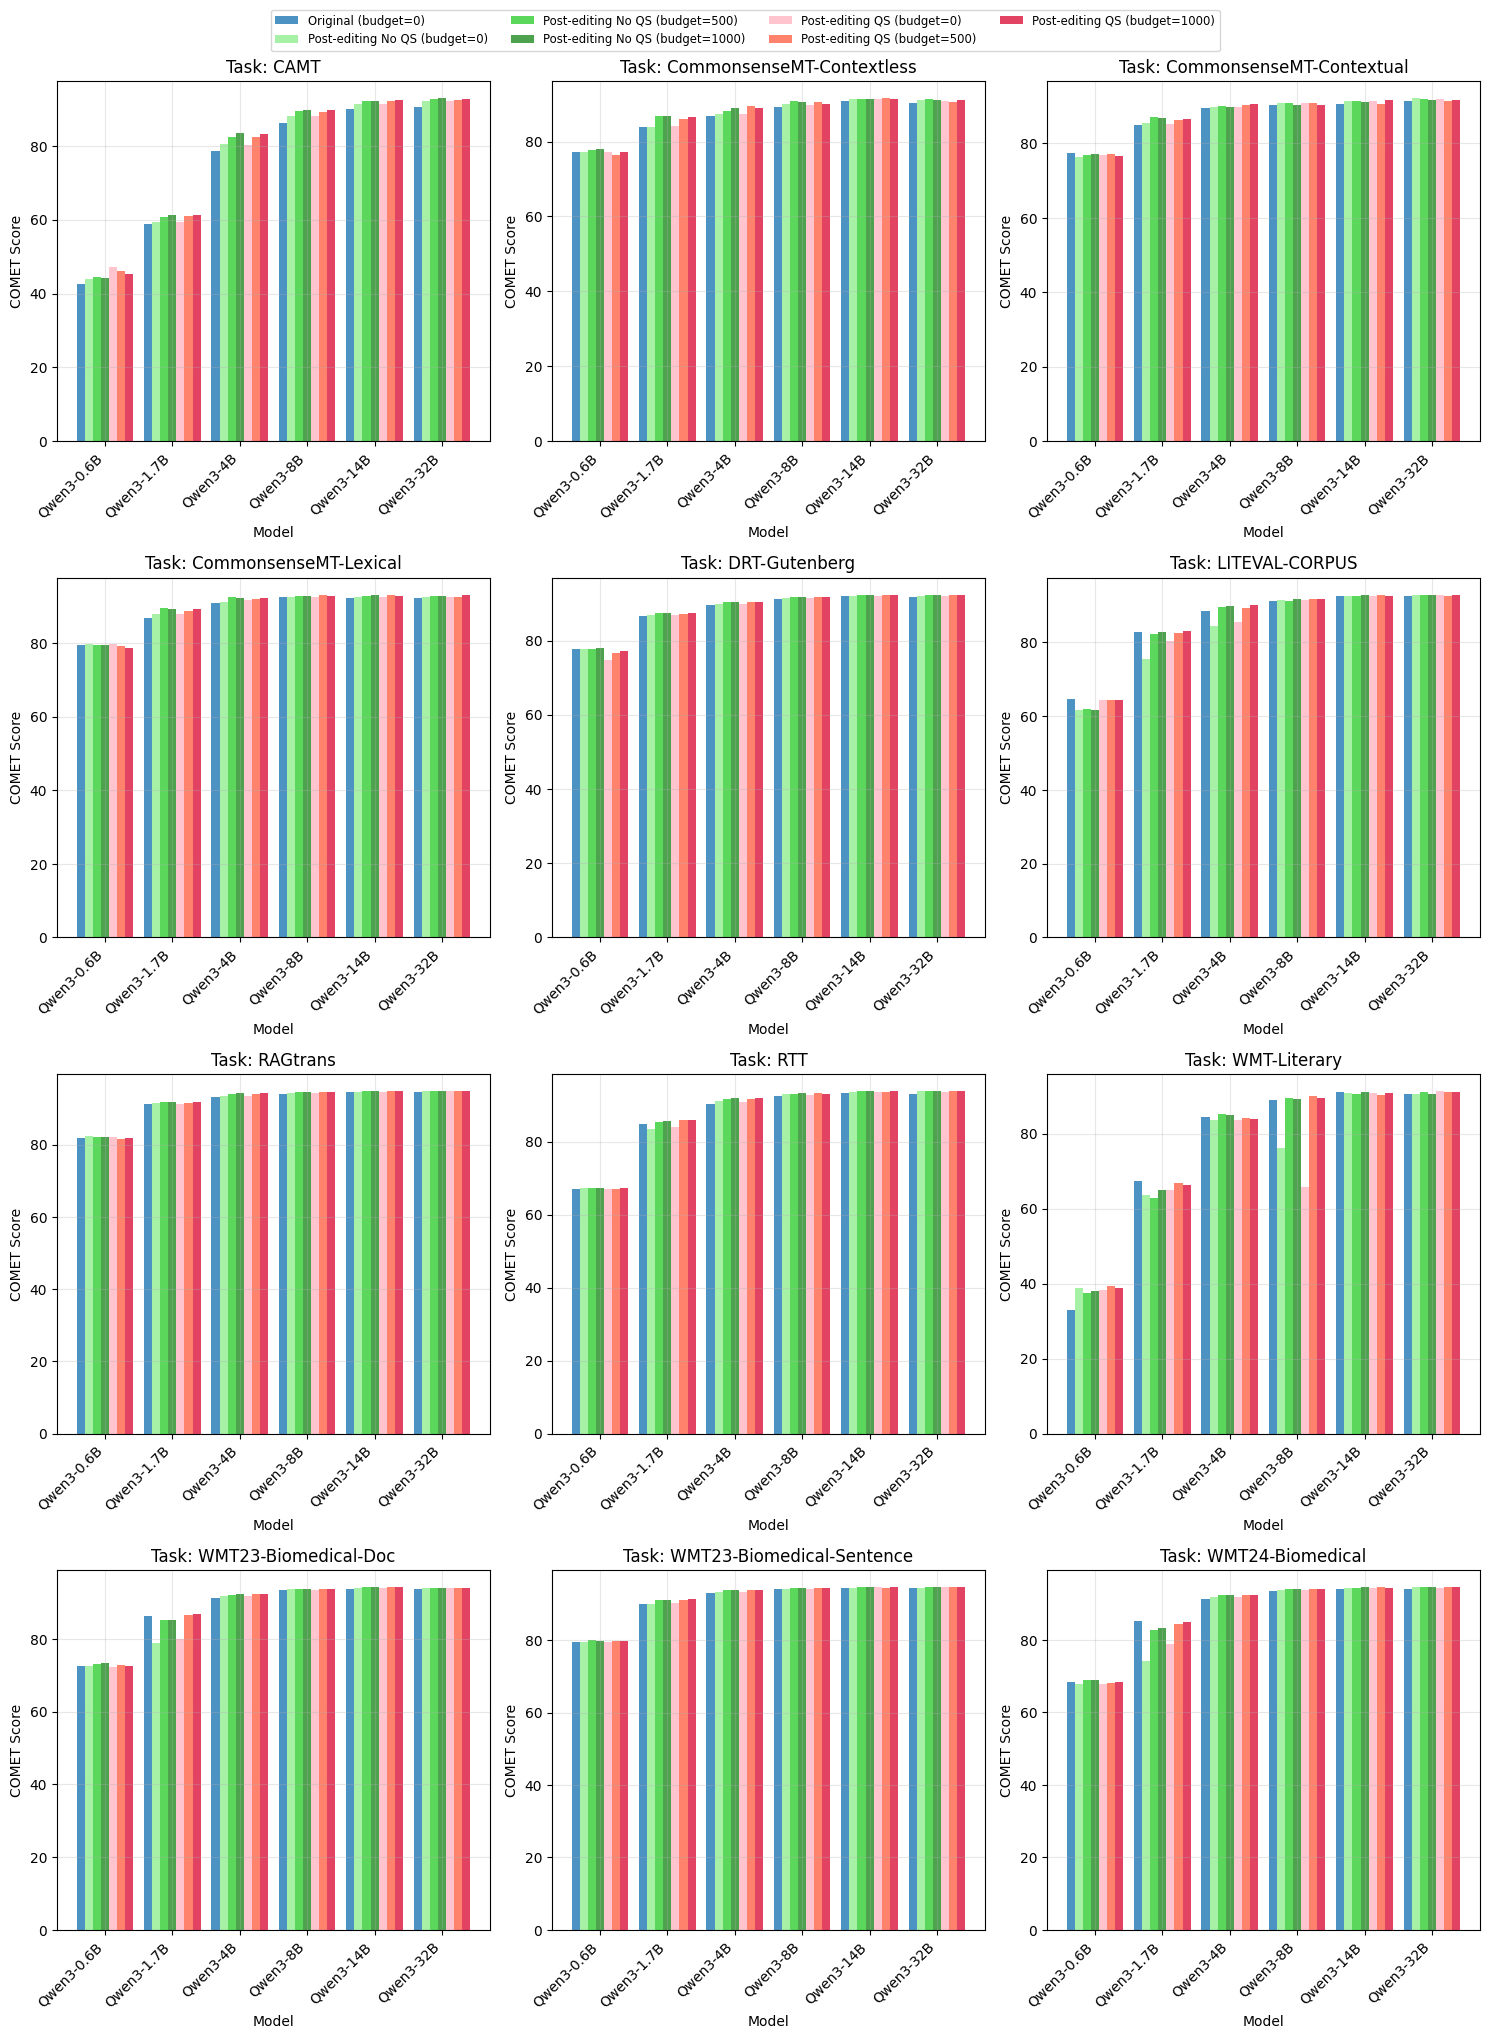

In [13]:
visualize_qwen_models_comparison(
    dfs_original_by_grf,
    dfs_post_editing_by_grf,
    dfs_post_editing_without_quality_score_by_grf,
)

In [18]:
improvement_df = generate_improvement_table(
    dfs_original_by_grf,
    dfs_post_editing_by_grf,
    dfs_post_editing_without_quality_score_by_grf,
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,CAMT,Qwen3-0.6B,42.597006,43.937170,44.382230,44.095893,47.233292,46.085302,45.422700
1,CAMT,Qwen3-1.7B,58.865884,59.366549,60.760093,61.271143,59.371365,60.973523,61.378377
2,CAMT,Qwen3-4B,78.683370,80.403132,82.453321,83.426408,80.310246,82.531546,83.327358
3,CAMT,Qwen3-8B,86.331875,87.970985,89.404099,89.653258,87.993161,89.272933,89.652617
4,CAMT,Qwen3-14B,90.107844,91.339569,92.121997,92.253664,91.402191,92.281506,92.312703
...,...,...,...,...,...,...,...,...,...
67,WMT24-Biomedical,Qwen3-1.7B,85.201667,74.073333,82.835000,83.233333,78.785000,84.518333,84.981667
68,WMT24-Biomedical,Qwen3-4B,91.181667,91.800000,92.363333,92.365000,91.725000,92.326667,92.481667
69,WMT24-Biomedical,Qwen3-8B,93.496667,93.893333,93.963333,94.066667,93.890000,94.010000,94.031667
70,WMT24-Biomedical,Qwen3-14B,94.130000,94.325000,94.466667,94.525000,94.453333,94.548333,94.460000


#### GEA_5

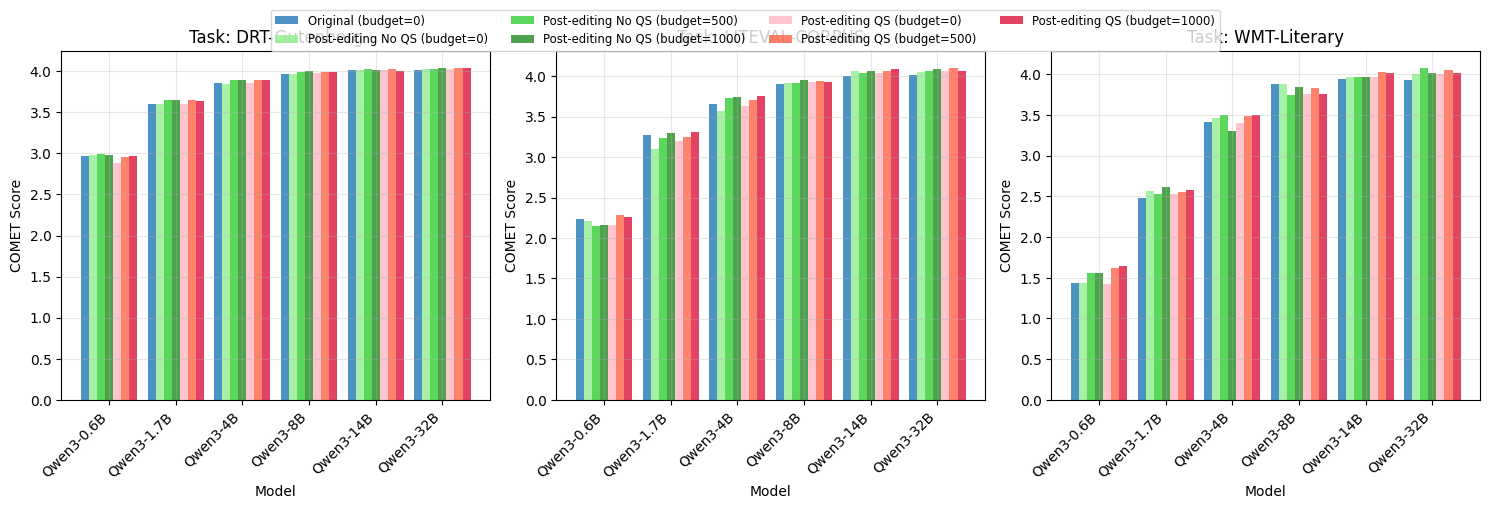

In [14]:
visualize_qwen_models_comparison(
    dfs_original_by_gea_5,
    dfs_post_editing_by_gea_5,
    dfs_post_editing_without_quality_score_by_gea_5,
)

In [19]:
improvement_df = generate_improvement_table(
    dfs_original_by_gea_5,
    dfs_post_editing_by_gea_5,
    dfs_post_editing_without_quality_score_by_gea_5,
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,DRT-Gutenberg,Qwen3-0.6B,2.966887,2.982000,2.998500,2.980500,2.885000,2.954000,2.966500
1,DRT-Gutenberg,Qwen3-1.7B,3.600104,3.606500,3.655500,3.652000,3.607000,3.647500,3.638500
2,DRT-Gutenberg,Qwen3-4B,3.855000,3.850500,3.899000,3.896500,3.851500,3.895500,3.888000
3,DRT-Gutenberg,Qwen3-8B,3.965204,3.972000,3.993000,3.998500,3.975000,3.993000,3.985000
4,DRT-Gutenberg,Qwen3-14B,4.009500,4.018000,4.024500,4.014500,4.016000,4.026000,4.002500
5,DRT-Gutenberg,Qwen3-32B,4.019000,4.030500,4.033000,4.040000,4.024500,4.034500,4.034500
6,LITEVAL-CORPUS,Qwen3-0.6B,2.239681,2.213240,2.148356,2.158444,2.164429,2.278689,2.261372
7,LITEVAL-CORPUS,Qwen3-1.7B,3.272565,3.094013,3.235418,3.291961,3.202593,3.251057,3.309495
8,LITEVAL-CORPUS,Qwen3-4B,3.651841,3.571563,3.727567,3.742859,3.625116,3.704844,3.753946
9,LITEVAL-CORPUS,Qwen3-8B,3.903551,3.909228,3.919432,3.951476,3.930518,3.935273,3.925084


#### GEA_100

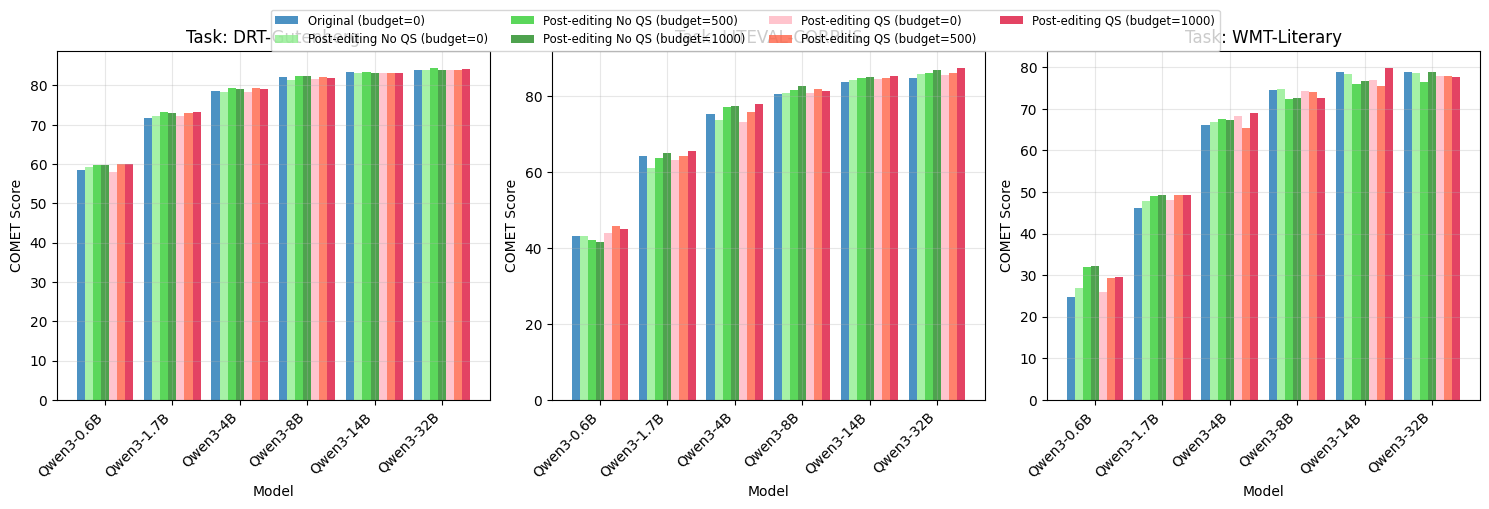

In [15]:
visualize_qwen_models_comparison(
    dfs_original_by_gea_100,
    dfs_post_editing_by_gea_100,
    dfs_post_editing_without_quality_score_by_gea_100,
)

In [20]:
improvement_df = generate_improvement_table(
    dfs_original_by_gea_100,
    dfs_post_editing_by_gea_100,
    dfs_post_editing_without_quality_score_by_gea_100,
)
# print(improvement_df.to_string(index=False))
improvement_df

,Task,Model,Original Score,Post-editing No QS (budget=0),Post-editing No QS (budget=500),Post-editing No QS (budget=1000),Post-editing QS (budget=0),Post-editing QS (budget=500),Post-editing QS (budget=1000)
0,DRT-Gutenberg,Qwen3-0.6B,58.420385,59.300000,59.772500,59.670000,58.103000,60.089590,60.143500
1,DRT-Gutenberg,Qwen3-1.7B,71.650026,72.310000,73.135000,73.107500,72.310000,73.067500,73.235000
2,DRT-Gutenberg,Qwen3-4B,78.667500,78.400000,79.427500,79.227500,78.347500,79.342500,79.035000
3,DRT-Gutenberg,Qwen3-8B,82.040663,81.442500,82.487500,82.292500,81.552500,82.252500,81.992500
4,DRT-Gutenberg,Qwen3-14B,83.345000,83.062500,83.492500,83.085000,83.205000,83.270000,83.202500
5,DRT-Gutenberg,Qwen3-32B,83.845000,83.822500,84.470000,83.910000,84.032500,84.040000,84.135000
6,LITEVAL-CORPUS,Qwen3-0.6B,43.264152,43.263808,42.175329,41.593408,44.066695,45.739071,45.110650
7,LITEVAL-CORPUS,Qwen3-1.7B,64.352042,60.972385,63.849646,64.952401,63.120209,64.177609,65.450063
8,LITEVAL-CORPUS,Qwen3-4B,75.403538,73.646590,77.231152,77.507209,73.273684,75.908810,77.873638
9,LITEVAL-CORPUS,Qwen3-8B,80.670837,80.840940,81.533916,82.693061,80.948987,81.896286,81.502199
